# IMPORT and standard tweaking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

#visualization option

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

In [3]:
viral=pd.read_csv(r'data/analysis/viral_charts_songs_2017-2020.csv')

In [4]:
viral['Artist'].value_counts()

Post Malone        100
Tones And I         94
Billie Eilish       93
Ariana Grande       76
Powfu               61
                  ... 
Soweto's Finest      1
Poli Ok              1
Casadilego           1
ZIW                  1
KSHMR                1
Name: Artist, Length: 4333, dtype: int64

In [5]:
viral[viral['Artist']=='Lil Pump']

,Position,Track Name,Artist,URL,filename,ID,date,country,group,duration_ms,popularity,acousticness,danceability,energy,key,instrumentalness,liveness,loudness,mode,speechiness,valence,tempo,loud_start


In [6]:
viral.columns

Index(['Position', 'Track Name', 'Artist', 'URL', 'filename', 'ID', 'date',
       'country', 'group', 'duration_ms', 'popularity', 'acousticness',
       'danceability', 'energy', 'key', 'instrumentalness', 'liveness',
       'loudness', 'mode', 'speechiness', 'valence', 'tempo', 'loud_start'],
      dtype='object')

In [7]:
len(viral.ID.unique())

6007

remarks on the features
* 'valence' indicates the 'happiness' the lower the score the sader the music. [refercence](https://community.spotify.com/t5/Content-Questions/Valence-as-a-measure-of-happiness/td-p/4385221)
* mode 0/1 indicates major/minor (dur/moll) 1=Major / 0=Minor

In [8]:
#rename column length to duration to match the kaggle dataframe
viral=viral.rename(columns={'length':'duration_ms'})


#### dtypes tweaking

In [9]:
viral.dtypes

Position              int64
Track Name           object
Artist               object
URL                  object
filename             object
ID                   object
date                 object
country              object
group                object
duration_ms           int64
popularity            int64
acousticness        float64
danceability        float64
energy              float64
key                   int64
instrumentalness    float64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
valence             float64
tempo               float64
loud_start          float64
dtype: object

In [10]:
#date to datetime
viral.date=pd.to_datetime(viral.date, format="%Y-%m-%d", yearfirst=True)

# mode and key are categroical values

#make mode categorical and name 'Major', 'Minor'
viral['mode'] = np.where(viral['mode'].apply(str)=='1','Major','Minor')

#make key categorical and label it more readable
viral['key'] = 'key_'+viral['key'].apply(str)

#introduce numeric column if viral or not 0/1
viral['viral']=1

In [11]:
# mapping country codes to real country names
keys=list(sorted(set(viral.country)))
values=['Argentina','Australia','Brazil','Canada','Germany','Egypt','Spain','United Kingdom','Indonesia','India','Iceland','Italy','Japan','Marocco','Mexico','New Zealand','Russia','Turkey','Ukraine','South Africa']
country_dict = dict(zip(keys, values))
viral['country']=viral['country'].map(country_dict) 

# CAN WE PREDICT IF SONGS ARE VIRAL SONGS
* Supervised learning model with K NEAREST NEIGHBORS
* Will the musical features of snongs labeled as viral be distinguishable enough?
* Using a large kaggle song data base as baseline to compare against songs from viral charts
* https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

#### Set Up Spotify dataset from Kaggle as baseline to compare against

In [12]:
kaggle=pd.read_csv(r'data/kaggle/data.csv')

In [13]:
#adding column indicating they are not the viral songs
kaggle['group']='base'

kaggle['viral']=0

In [14]:
# mode and key are categroical values

#make mode categorical and name 'Major', 'Minor'
kaggle['mode'] = np.where(kaggle['mode'].apply(str)=='1','Major','Minor')

#make key categorical and label it more readable
kaggle['key'] = 'key_'+kaggle['key'].apply(str)


#### subsetting for years 2014-2020

In [15]:
# only want to keep songs from 2015 to 2020 to avoid accidentally measuring change in music production
base=kaggle[kaggle['year'].isin([2014,2015,2016,2017,2018,2019,2020,2021])].reset_index(drop=True)
print('# of records: ',len(base))
#sadly reissues of old songs cannot be filterd out (ex. Frank Sinatra and Joni Mitchel)

# of records:  20234


# SET UP FOR MODELLING
* create joint dataframe for analysis
* check multicollinearity
* check outliers
* create dummies for categorical variable (ex key & mode)
* standardize continuous variables

### create joint dataframe 
create joint df of viral charts songs and songs from kaggle DB I want to compare against

In [16]:
# list of relevant columns
continuous_feat=[
            "acousticness",
            "danceability",
            "duration_ms",
            "energy",
            "instrumentalness",
            "liveness",
            "loudness",
            "speechiness",
            "tempo",
            "valence"]

categorical_feat=["key","mode"]

target_feat=['viral']

#### DATA FRAME ORIGINAL VALUES

#### joint dataframe with true values 
named: analysis_true

In [17]:
#concat viral DF with DF from kaggle that i use as base
analysis_true=pd.concat([viral[target_feat+categorical_feat+continuous_feat],
                        base[target_feat+categorical_feat+continuous_feat]
                        ],
                       axis=0,
                        ignore_index=True)

#### DATA FRAME: SCALED AND STANDARDIZED
#### joint dataframe with standardized continuous variables
named: analysis_stan

In [18]:
from sklearn.preprocessing import StandardScaler


In [19]:
# fit without transform for later use when applying to new data 
# copy=False parameter overrites the values in the data frame instead of jus returning the standardized data
scaler = StandardScaler(copy=False).fit(analysis_true[continuous_feat])

In [20]:
analysis_stan=analysis_true

In [21]:
#standardize the contnuous feature only
analysis_stan[continuous_feat]=pd.DataFrame(StandardScaler(copy=False).fit_transform(analysis_true[continuous_feat]),columns=continuous_feat)

### checking multicollinearity

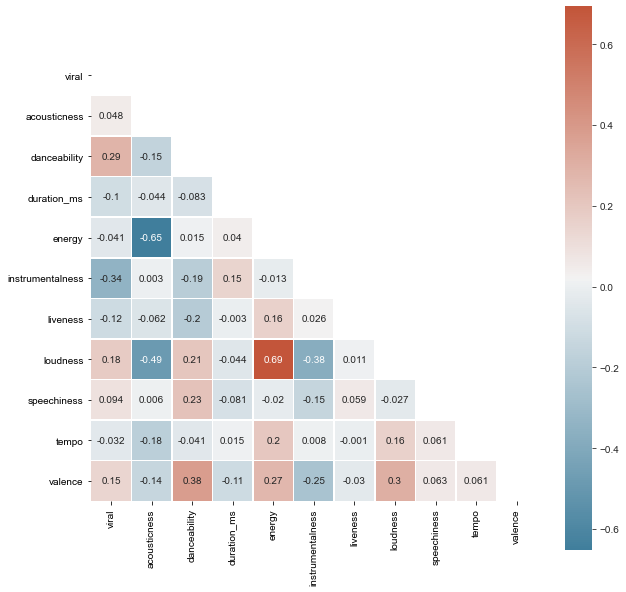

In [22]:
#
corr = round(analysis_stan.corr(),3)
f, ax = plt.subplots(figsize=(10, 10))
sns.set_style("darkgrid")
mask = np.triu(np.ones_like(corr, dtype=bool)) # removing the other side of the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap
sns.heatmap(corr,mask=mask,cmap=cmap,linewidths=.5,square=True,annot=True)
plt.show()

#### Create dummies of categorical features

In [23]:
from sklearn.preprocessing import OneHotEncoder
#picking only the categroical vairbles : key and mode
cat = analysis_stan[categorical_feat]
enc = OneHotEncoder()
cat_encoded = pd.DataFrame(enc.fit_transform(cat).toarray(), columns = enc.get_feature_names())

#### Setting up X and y

In [24]:
X = pd.concat((analysis_stan[continuous_feat], cat_encoded), axis=1)
y=analysis_stan['viral']
X.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,x0_key_0,x0_key_1,x0_key_10,x0_key_11,x0_key_2,x0_key_3,x0_key_4,x0_key_5,x0_key_6,x0_key_7,x0_key_8,x0_key_9,x1_Major,x1_Minor
0,-0.729603,1.193705,-0.253564,0.426470,-0.505215,-0.549543,0.653589,-0.443116,0.568695,1.961139,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.697026,0.244674,-0.239483,-0.307458,-0.505207,-0.429113,0.253990,-0.278012,-1.059601,0.276622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.146859,0.215563,-0.268660,1.092440,-0.505205,-0.702662,1.193220,0.311402,-0.838097,-0.988820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.694309,1.024859,-0.300585,0.548791,-0.467577,0.775193,0.501849,-0.218985,0.099295,-0.758740,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.268362,-0.221108,-0.362406,0.421939,-0.505215,0.230388,0.167385,0.790462,-0.721948,0.243753,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Split test and train


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4)

# K NEAREST NEIGHBOUR
* distance based algorithms demand that all variables need to be standardized
* they all need to be on the same scale 

### model and predictions

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knear_model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
knear_pred = knear_model.predict(X_test)

### Evaluate k nearest neighbour w/ score

In [27]:
print(knear_model.score(X_test, y_test))
print(pd.Series(knear_pred).value_counts())

0.7535854616895874
0    11706
1     8654
dtype: int64


### Evaluate k nearest neighbours w/ precision, recall and f1

In [28]:
#evaluate k nearest neighbour: eval_knear
from sklearn.metrics import precision_score, recall_score, f1_score

eval_knear={'Precision': precision_score(y_test, knear_pred, pos_label=1),#knear_pred predicitons of k nearest neighbour
            'Recall': recall_score(y_test, knear_pred, pos_label=1),
            'F1-Score': f1_score(y_test, knear_pred, pos_label=1)}

pd.DataFrame(eval_knear,index=[0]).style.bar(color='lightblue', vmin=0.0, vmax=1.0)

,Precision,Recall,F1-Score
0,0.681997,0.722664,0.701742


### Evaluate k nearest neighbours w/ Confusion Matrix and heatmap

In [29]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, knear_pred)#knear_pred predicitons of k nearest neighbour
print(cf_matrix)


[[9441 2752]
 [2265 5902]]


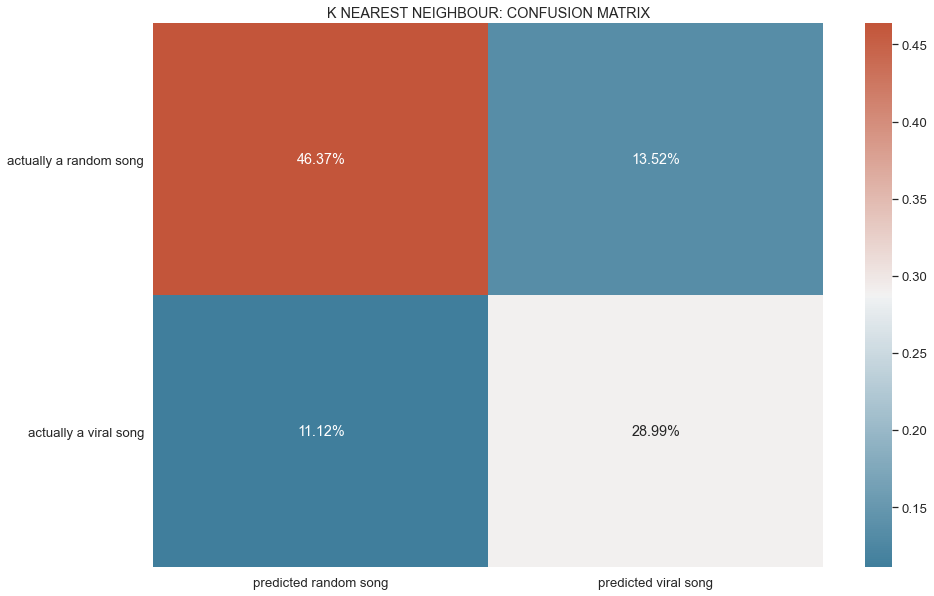

In [30]:
plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap
sns.set(font_scale=1.2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap=cmap,xticklabels=[ 'predicted random song', 'predicted viral song'],
            yticklabels=['actually a random song','actually a viral song']).set_title('K NEAREST NEIGHBOUR: CONFUSION MATRIX')
plt.yticks(rotation = 0)
plt.show()


# DECISION TREE

In [31]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)


### Evaluate decision tree

In [32]:
dt_model.score(X_test, y_test)

0.76262278978389

In [33]:
#evaluate decision tree : eval_dt
from sklearn.metrics import precision_score, recall_score, f1_score
eval_dt={'Precision': precision_score(y_test, dt_pred, pos_label=1),
            'Recall': recall_score(y_test, dt_pred, pos_label=1),
            'F1-Score': f1_score(y_test, dt_pred, pos_label=1)}

pd.DataFrame(eval_dt,index=[0]).style.bar(color='lightblue', vmin=0.0, vmax=1.0)

,Precision,Recall,F1-Score
0,0.686382,0.751684,0.717550


confusion matrix: 
 [[9388 2805]
 [2028 6139]]


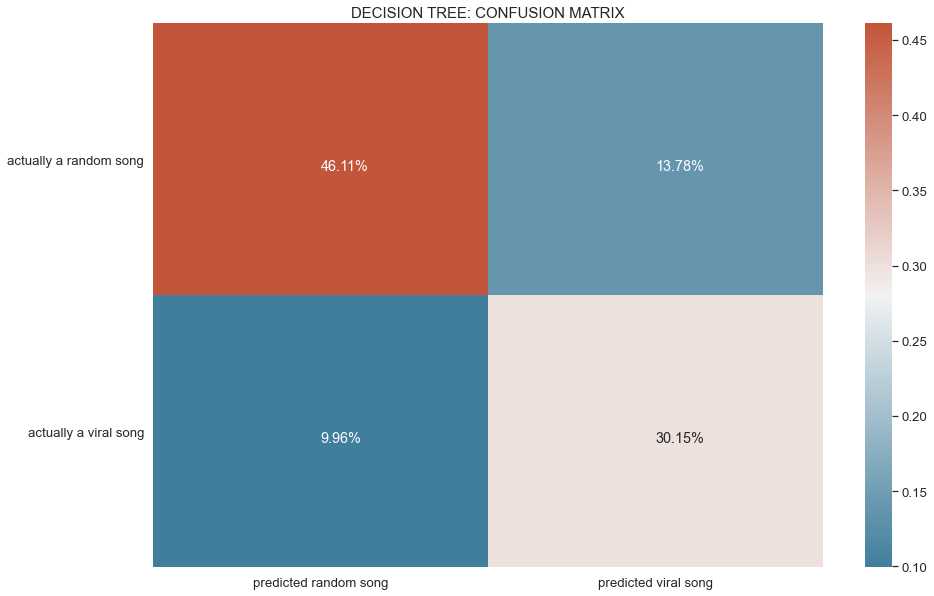

In [34]:
cf_matrix = confusion_matrix(y_test, dt_pred) #dt_pred : predictions decision tree
print('confusion matrix: \n',cf_matrix)
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap

akws = {'ha': 'left','va': 'top'}

ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, annot_kws=akws,
            fmt='.2%', cmap=cmap,xticklabels=[ 'predicted random song', 'predicted viral song'],
            yticklabels=['actually a random song','actually a viral song'])
plt.yticks(rotation = 0)
plt.title('DECISION TREE: CONFUSION MATRIX', size=15)
plt.show()

### Feature importance
in decision tree

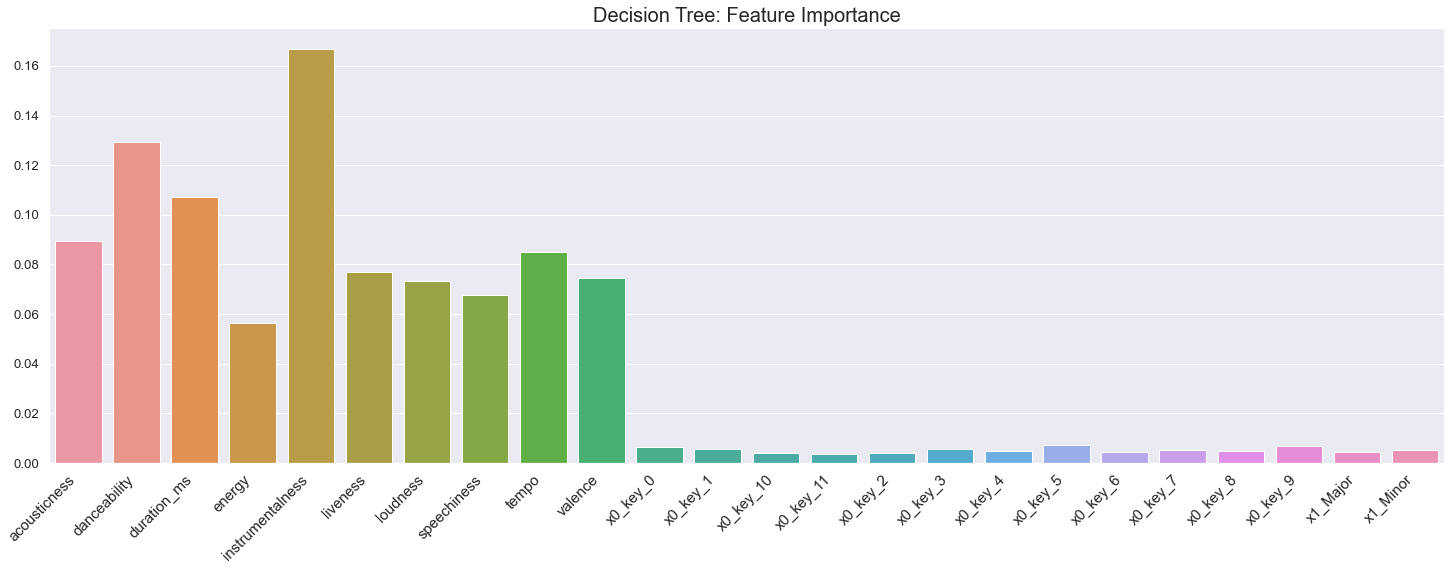

In [35]:
# feature importance embedded in y axis
f, ax = plt.subplots(figsize=(25, 8))
ax = sns.barplot(x=X.columns, 
                 y=dt_model.feature_importances_).set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right', size = 15)
plt.title('Decision Tree: Feature Importance', size=20)
plt.show()


In [36]:
pd.DataFrame(dict(zip(X.columns, dt_model.feature_importances_)),index=[0]).T.rename(columns={0:'importance'}).sort_values(by='importance',ascending=False).head().style.bar(color='lightblue',vmin=0.0, vmax=1.0)

,importance
instrumentalness,0.166847
danceability,0.129223
duration_ms,0.107192
acousticness,0.089377
tempo,0.085034


# RANDOM FOREST

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier().fit(X_train, y_train)
forest_pred = forest_model.predict(X_test)


### Evaluate decision tree

In [38]:
forest_model.score(X_test, y_test)

0.8201866404715128

In [39]:
#evaluate decision tree : eval_dt
from sklearn.metrics import precision_score, recall_score, f1_score
eval_forest={'Precision': precision_score(y_test, forest_pred, pos_label=1),
            'Recall': recall_score(y_test, forest_pred, pos_label=1),
            'F1-Score': f1_score(y_test, forest_pred, pos_label=1)}

pd.DataFrame(eval_forest,index=[0]).style.bar(color='lightblue', vmin=0.0, vmax=1.0)

,Precision,Recall,F1-Score
0,0.802335,0.732093,0.765606


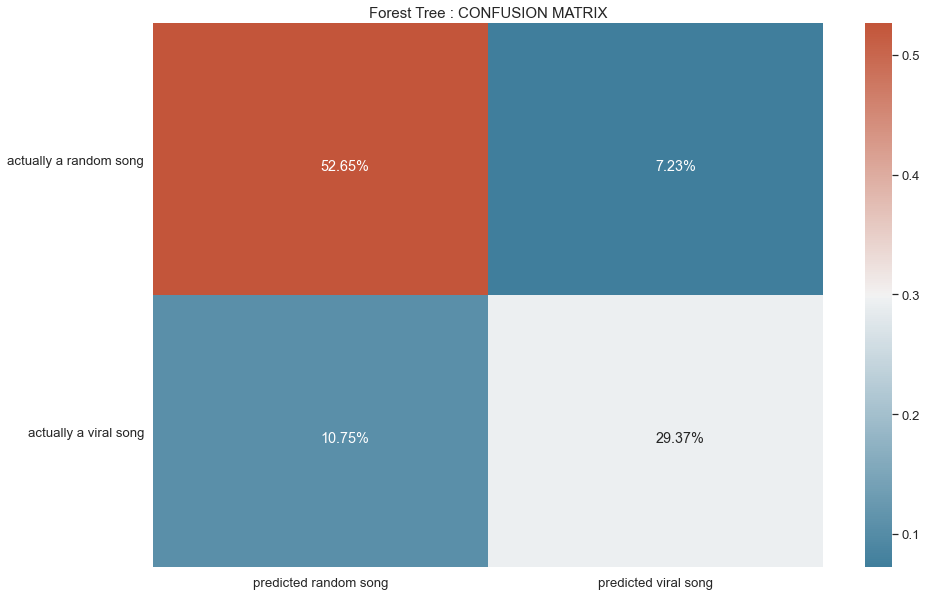

In [40]:
cf_matrix = confusion_matrix(y_test, forest_pred) #dforest_pred : predictions forest tree
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap

akws = {'ha': 'left','va': 'top'}

ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, annot_kws=akws,
            fmt='.2%', cmap=cmap,xticklabels=[ 'predicted random song', 'predicted viral song'],
            yticklabels=['actually a random song','actually a viral song'])
plt.yticks(rotation = 0)
plt.title('Forest Tree : CONFUSION MATRIX', size=15)
plt.show()

### Feature importance
in decision tree

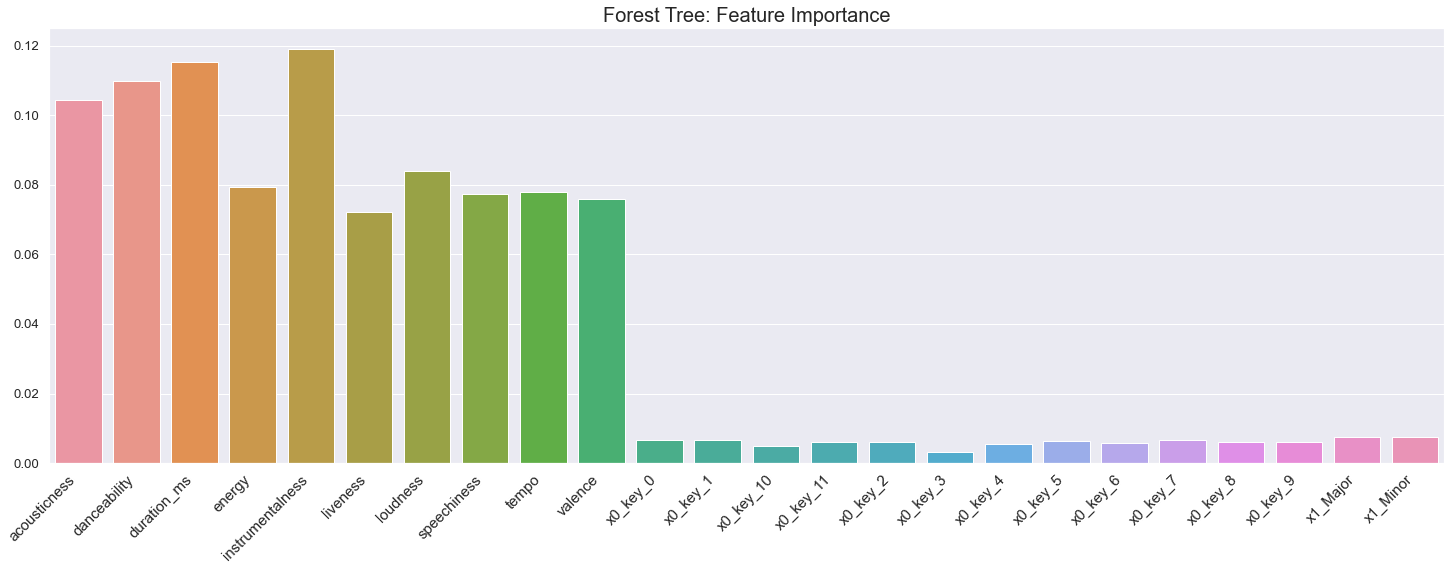

In [41]:
# feature importance embedded in y axis
f, ax = plt.subplots(figsize=(25, 8))
ax = sns.barplot(x=X.columns, 
                 y=forest_model.feature_importances_).set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right', size = 15)
plt.title('Forest Tree: Feature Importance', size=20)
plt.show()


#  RADAR PLOT
### FEATURE MEANS OF VIRAL SONGS VERSUS DER FEATURE MEANS OF KAGGLE SONGS
reference: https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way

In [42]:
labels=np.array(analysis_true[continuous_feat].columns)
viral_songs_stats=analysis_true[continuous_feat][analysis_true['viral']==1].mean().values

###
base_songs_stats=analysis_true[continuous_feat][analysis_true['viral']==0].mean().values


In [43]:
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
###
viral_songs_stats=np.concatenate((viral_songs_stats,[viral_songs_stats[0]]))
base_songs_stats=np.concatenate((base_songs_stats,[base_songs_stats[0]]))

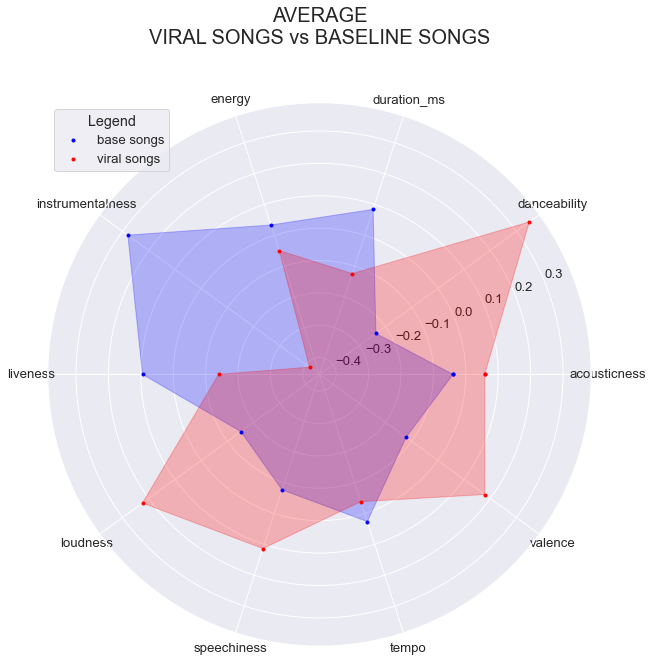

In [44]:
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
plot1=ax.plot(angles, base_songs_stats, '.', linewidth=2, label='base songs',color='blue')
plot2=ax.plot(angles, viral_songs_stats, '.', linewidth=2, label='viral songs',color='red')
ax.fill(angles, base_songs_stats, alpha=0.25, color='blue')
ax.fill(angles, viral_songs_stats, alpha=0.25, color='red')
ax.set_thetagrids((angles * 180/np.pi)[0:10], labels)
plt.legend(title='Legend', loc='upper left')
ax.set_title('AVERAGE\nVIRAL SONGS vs BASELINE SONGS\n\n',size=20)
ax.grid(True)

In [45]:
#################################################

# RUN PREDICTOR

In [46]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.oauth2 as oauth2
import os
import re

In [47]:
def predict_hit(url,continuous_feat,categorical_feat):
    
    ###
    """my_client_id=os.getenv('spoti_CLIENT_ID')
    my_client_secret=os.getenv('spoti_CLIENT_SECRET')
    token = SpotifyClientCredentials(client_id=my_client_id, client_secret=my_client_secret)
    #token to pull publicly available data like music analysis data
    cache_token = token.get_access_token()
    sp = spotipy.Spotify(cache_token)"""
    
    my_client_id=os.getenv('spoti_CLIENT_ID')
    my_client_secret=os.getenv('spoti_CLIENT_SECRET')
    sp=spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=my_client_id, client_secret=my_client_secret))

    ###
    
    meta_feat=['ID','Track_Name','Artist']
    
    #set up to call spotify API
    song_id=re.findall(r'\d\w+',str(url))[0]
    
    meta = sp.track(song_id)
    features = sp.audio_features(song_id)
    analysis= sp.audio_analysis(song_id)
    
    #create dictionary
    keys=[i for i in meta_feat+continuous_feat+categorical_feat] #these lists should contain the nemes of all features I need
    values=[song_id,
            meta['name'],#song title
            meta['artists'][0]['name'],#artist name
            features[0]['acousticness'],
            features[0]['danceability'],
            meta['duration_ms'],
            features[0]['energy'],
            features[0]['instrumentalness'],
            features[0]['liveness'],
            features[0]['loudness'],
            features[0]['speechiness'],
            features[0]['tempo'],
            features[0]['valence'],
            features[0]['key'],
            features[0]['mode']]

    df=pd.DataFrame(dict(zip(keys,values)),index=[0])
    
    #standardize the contnuous feature only: using the scaler i fitted with all continuouse variables
    df[continuous_feat]=pd.DataFrame(scaler.transform(df[continuous_feat]),columns=continuous_feat)
    
    #recreate dummies for keys
    for i in range(0,12):
        if df['key'][0] == i:
            df[f'x0_key_{i}']=1.0
        else:
            df[f'x0_key_{i}']=0.0
    df.drop('key',axis=1,inplace=True)
    
    #recreate dummies for keys
    df['x1_Major']=np.where(df['mode'] == 1,1.0,0.0)
    df['x1_Minor']=np.where(df['mode'] == 0,1.0,0.0)
    df.drop('mode',axis=1, inplace=True)

    X_NEW=df.drop(['ID','Track_Name','Artist'],axis=1)
    #X_NEW.columns=continuous_feat+list(cat_encoded.columns)
    
    #making prediction with random forest
    result=forest_model.predict(X_NEW)
    probability=round(forest_model.predict_proba(X_NEW)[0][1],2) #probablitiy positiv
    
    print('\n------')
    if result==1:
        return print(f"YEAH! THE COMMITTEE OF MEME CATS APPROVES!\n„{(df['Track_Name'][0])}“ by {df['Artist'][0].upper()} will go viral\n------\n„{(df['Track_Name'][0])}“ by {df['Artist'][0].upper()} meets {round(probability*100,2)}% of this model's viral qualities")
    else:
        return print(f"NOPE! The song „{(df['Track_Name'][0])}“ doesn't have what it takes - {df['Artist'][0].upper()} ain't on the meme-team\n------\n„{(df['Track_Name'][0])}“ by {df['Artist'][0].upper()} only meets this model's viral qualities by {round(probability*100,2)}%")
    


In [48]:
###THOMAS: MIT DEN CATEGORICAL VALUES GIBTS NOCH ÄRGER DER ONE HOT ENCODER RETOURNIERT NUR 2 WERTE!!!

In [49]:
print('Paste URL of Spotify Song\nShould look like this: https://open.spotify.com/track/7qzftATxwdp8G78aMmizXN')
url=input().strip(' ')
predict_hit(url,continuous_feat,categorical_feat)

Paste URL of Spotify Song
Should look like this: https://open.spotify.com/track/7qzftATxwdp8G78aMmizXN
https://open.spotify.com/track/7qzftATxwdp8G78aMmizXN

------
NOPE! The song „Too Much Money“ doesn't have what it takes - AUTOMATIC ain't on the meme-team
------
„Too Much Money“ by AUTOMATIC only meets this model's viral qualities by 23.0%


# Songs predicted a viral
* Vossi Bop Stormzy https://open.spotify.com/track/5DXKtoZLm31msT7tNGNHLG&si=74197ab0140b4678
* Cradle: https://open.spotify.com/track/18A7ha5BitZjmdHTCwXFbU
* Airwaves https://open.spotify.com/track/5CqkgDH8QZjSqqI3HmYxDD&si=e7b286fbe9cd46d9
* Therefore I am: Eilish https://open.spotify.com/track/54bFM56PmE4YLRnqpW6Tha&si=4d28290bf50242ad
* Heat Waves https://open.spotify.com/track/3USxtqRwSYz57Ewm6wWRMp&si=48d27497214e40f0
* Capital Bra https://open.spotify.com/track/0Dlcu2fgHklOnajVu2dUNU&si=d7f89487035e4e63
* Apache Fame https://open.spotify.com/track/0QjjaCaXE45mvhCnV3C0TA&si=31f9ea9d3c2443bf
* The Weekend https://open.spotify.com/track/0VjIjW4GlUZAMYd2vXMi3b&si=593d03f738ad4d58

Worst negativ rating
* Love will tear us apart https://open.spotify.com/track/34iOH7LY3vme5rQxsVILZ4&si=051da9cc0c324f8b

In [50]:
viral[viral['Artist']=='Weekend']

,Position,Track Name,Artist,URL,filename,ID,date,country,group,duration_ms,popularity,acousticness,danceability,energy,key,instrumentalness,liveness,loudness,mode,speechiness,valence,tempo,loud_start,viral


# NOTES

PLOTS
https://seaborn.pydata.org/tutorial/distributions.html